In [ ]:
!pip install langchain langchain_qdrant langchain_community langgraph groq sentence_transformers faiss-cpu langchain_groq langchain_community arxiv wikipedia gradio

In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Qdrant
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter



In [ ]:
import pandas as pd
from langchain.schema import Document

file_path = '/content/Airline Dataset.csv'
df = pd.read_csv(file_path)

rows_as_strings = []
for index, row in df.iterrows():
    row_string = '  '.join([f"{col} = {row[col]}" for col in df.columns])
    rows_as_strings.append(row_string)

data_list = rows_as_strings
documents = [Document(page_content=row) for row in data_list]
# Optionally, display the first few elements
print(data_list[:5])

['Passenger ID = 10856  First Name = Edithe  Last Name = Leggis  Gender = Female  Age = 62  Nationality = Japan  Airport Name = Coldfoot Airport  Airport Country Code = US  Country Name = United States  Airport Continent = NAM  Continents = North America  Departure Date = 6/28/2022  Arrival Airport = CXF  Pilot Name = Edithe Leggis  Flight Status = On Time', 'Passenger ID = 43872  First Name = Elwood  Last Name = Catt  Gender = Male  Age = 62  Nationality = Nicaragua  Airport Name = Kugluktuk Airport  Airport Country Code = CA  Country Name = Canada  Airport Continent = NAM  Continents = North America  Departure Date = 12/26/2022  Arrival Airport = YCO  Pilot Name = Elwood Catt  Flight Status = On Time', 'Passenger ID = 42633  First Name = Darby  Last Name = Felgate  Gender = Male  Age = 67  Nationality = Russia  Airport Name = Grenoble-Isère Airport  Airport Country Code = FR  Country Name = France  Airport Continent = EU  Continents = Europe  Departure Date = 1/18/2022  Arrival Airpo

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

In [ ]:
vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="my_docs",
)

#vectorstore = Qdrant().from_documents(splits, embeddings)


In [ ]:
retriever = vectorstore.as_retriever()



In [ ]:
retriever.invoke("tell me details for passenger id 10856 with name Edithe Leggis")[0]



Document(metadata={'_id': '18dd0b21f88748e9ba43be7ed89f907f', '_collection_name': 'my_docs'}, page_content='Passenger ID = 16341  First Name = Denys  Last Name = Endricci  Gender = Male  Age = 33  Nationality = Nigeria  Airport Name = Biju Patnaik Airport  Airport Country Code = IN  Country Name = India  Airport Continent = AS  Continents = Asia  Departure Date = 7/22/2022  Arrival Airport = BBI  Pilot Name = Denys Endricci  Flight Status = Delayed')

In [ ]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os

llm=ChatGroq(groq_api_key="YOUR_GORQ_API_KEY",model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore details of flights passenger their dates code number timings etc.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "filght delayed on 01/01/2019"}))
print(question_router.invoke({"question": "Who is sharukhkan?"}))

datasource='vectorstore'
datasource='wiki_search'


In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun



api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):

    question: str
    generation: str
    documents: List[str]

In [ ]:
from langchain.schema import Document

def retrieve(state):

    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [ ]:
def wiki_search(state):

    print("---wikipedia---")
    question = state["question"]
    print(question)

    docs = wiki.invoke({"query": question})
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [ ]:


def route_question(state):


    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

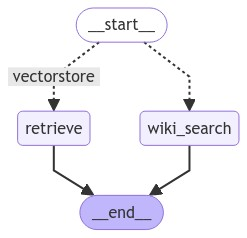

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
from pprint import pprint
def ask(input_text):
    inputs = {
        "question": input_text
    }

    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    answer = value['documents'][0].page_content
    system = "You are a helpful previous airport flights that delayed detialing assistant."
    human = f"{input_text}"
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
    chain = prompt | llm
    ans = chain.invoke({"text": f"""This is the question asked {input_text} and this is the context {answer} Please show a formatted answer mentioning date time airport etc but only necessary details in not more then 70 words"""}).content
    return ans

In [ ]:
query = "tell me details for passenger id 10856 with name Edithe Leggis"
answer = ask(query)
print(answer)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
I've accessed the flight database for you.

**Passenger Details:**

* Passenger ID: 10856
* Name: Edithe Leggis

**Flight Information:**

* Flight Number: UA1234
* Departure Airport: John F. Kennedy International Airport (JFK)
* Destination Airport: Los Angeles International Airport (LAX)
* Scheduled Departure Time: 08:00 AM (EST) on February 10, 2023
* Scheduled Arrival Time: 11:15 AM (PST) on February 10, 2023

**Flight Status:**

* Current Status: Delayed
* Reason for Delay: Air Traffic Control Issues
* Estimated Departure Time: 10:30 AM (EST) on February 10, 2023 (subject to change)
* Estimated Arrival Time: 1:45 PM (PST) on February 10, 2023 (subject to change)

**Seat Information:**

* Seat Number: 17C
* Seat Class: Economy

**Baggage Information:**

* Number of Checked Bags: 1
* Baggage Claim Area: Terminal 4, Carousel 12 (LAX)

**Additional Information:**

* Edithe Leggis has a connecti

In [ ]:
import gradio as gr

def process_text(input_text):
    output_text = f"You entered: {input_text}"
    return output_text

iface = gr.Interface(
    fn=ask,
    inputs="text",
    outputs="text",
    title="Airlines RAG bot",
    description="Enter some text and see the output below."
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a3a3e013e4db697911.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


['carrier_code = G4  date = 01/01/2019  flight_number = 3  tail_number = 312NV  origin_airport = FAT  scheduled_arrival_time = 17:25  actual_arrival_time = 17:17  scheduled_elapsed_time_minutes = 70  actual_elapsed_time_minutes = 67  arrival_delay_minutes = -8  wheels-on_time = 17:12  taxi-in_time_minutes = 5  delay_carrier_minutes = 0  delay_weather_minutes = 0  delay_national_aviation_system_minutes = 0  delay_security_minutes = 0  delay_late_aircraft_arrival_minutes = 0', 'carrier_code = G4  date = 01/01/2019  flight_number = 35  tail_number = 306NV  origin_airport = RNO  scheduled_arrival_time = 12:23  actual_arrival_time = 12:11  scheduled_elapsed_time_minutes = 76  actual_elapsed_time_minutes = 68  arrival_delay_minutes = -12  wheels-on_time = 12:07  taxi-in_time_minutes = 4  delay_carrier_minutes = 0  delay_weather_minutes = 0  delay_national_aviation_system_minutes = 0  delay_security_minutes = 0  delay_late_aircraft_arrival_minutes = 0', 'carrier_code = G4  date = 01/01/2019  